In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from crepes import WrapRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from copy import copy

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Conformalized quantile regression

In the previous notebook we added a prediction interval to a point prediction. In this notebook we will calibrate the predicted distribution of a probabilistic model. This will be applied on quantile regression, therefore the method is called conformalized quantile regression.

Quantile regression trains a model for every quantile that is predicted. For a full distribution, many quantiles are predicted. A different way of seeing a full distribution is as a collection of prediction intervals. Conformilizing the quantile regression repeats the calibration for every prediction interval of the distribution. To simplify the code in this notebook, only a single prediction interval is calibrated.

In this notebook:
* [Input](#input)
* [Baseline model: quantile regression](#quantile_regr)
* [Conformal prediction manually for understanding](#manual)
* [Conformal prediction with package MAPIE](#MAPIE)
* [Conformal prediction with package crepes](#crepes)
* [Comparison of results: manual, crepes and MAPIE](#comparison)

Information about the crepes and MAPIE packages:
* https://crepes.readthedocs.io/en/latest/crepes.html
* https://mapie.readthedocs.io/en/latest/

# Input <a class="anchor" id="input"></a>

Here you can select the confidence level of your prediction interval.

In [2]:
dataset = fetch_openml(name="house_sales", version=3, parser="auto")

X = dataset.data.values.astype(float)
y = dataset.target.values.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

# Train a point prediction model as a baseline
baseline_model = LGBMRegressor(objective='quantile', alpha=0.5)
fitted_baseline_model = copy(baseline_model).fit(X_prop_train, y_prop_train)

# Choose your confidence level of the prediction interval
confidence = 0.90

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 8104, number of used features: 21
[LightGBM] [Info] Start training from score 451200.500000


In [3]:
# Some functionality

def plot_impression_of_subset(point, interval):
    plt.plot(point)
    plt.plot(interval)
    plt.legend(['Point prediction', 'Lower bound of prediction interval', 'Upper bound of prediction interval'])
    plt.xlabel('Impression of subset of samples')
    plt.ylabel('y')

# Baseline model: Quantile regression <a class="anchor" id="quantile_regr"></a>

Quantile regression is the baseline model for conformalized quantile regression.

In [4]:
# Point prediction
point_prediction = fitted_baseline_model.predict(X_test)

In [5]:
# Quantile regression for single interval
quantile_regression_prediction_intervals = np.zeros([len(X_test), 2])
lower_bound_model = LGBMRegressor(objective = 'quantile', alpha = 0.05)
lower_bound_model.fit(X_prop_train, y_prop_train)
quantile_regression_prediction_intervals[:, 0] = lower_bound_model.predict(X_test)

higher_bound_model = LGBMRegressor(objective = 'quantile', alpha = 0.95)
higher_bound_model.fit(X_prop_train, y_prop_train)
quantile_regression_prediction_intervals[:,1] = higher_bound_model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 8104, number of used features: 21
[LightGBM] [Info] Start training from score 212000.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 8104, number of used features: 21
[LightGBM] [Info] Start training from score 1154699.750000


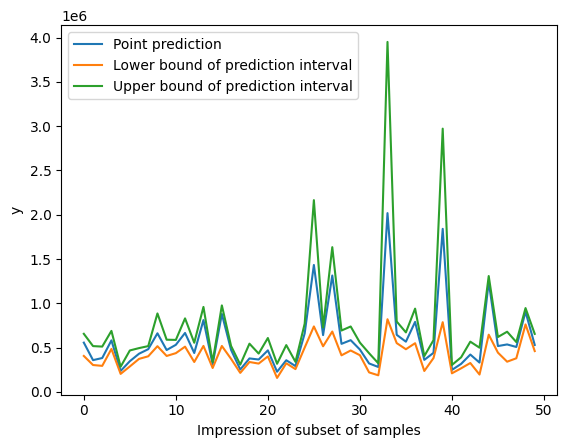

In [6]:
plot_impression_of_subset(point_prediction[:50], quantile_regression_prediction_intervals[:50, :])

Here it becomes visible that the quantile regression model is not well calibrated. In the 90% confidence interval (5% to 95%) only around 83% of the test set is captured.

In [7]:
y_test_in_prediction_interval = (y_test >= quantile_regression_prediction_intervals[:, 0]).astype(int) * (y_test <= quantile_regression_prediction_intervals[:, 1]).astype(int)
print(f'Percentage of test set within prediction interval with {confidence}: {y_test_in_prediction_interval.mean()}')

Percentage of test set within prediction interval with 0.9: 0.8248357546034978


# Conformalized quantile regression manually for understanding <a class="anchor" id="manual"></a>



In [8]:
quantile_regression_calibration_intervals = np.zeros([len(X_cal), 2])
quantile_regression_calibration_intervals[:, 0] = lower_bound_model.predict(X_cal)
quantile_regression_calibration_intervals[:, 1] = higher_bound_model.predict(X_cal)

In [9]:
y_cal_in_prediction_interval = (y_cal >= quantile_regression_calibration_intervals[:, 0]).astype(int) * (y_cal <= quantile_regression_calibration_intervals[:, 1]).astype(int)
print(f'Percentage of calibration set within prediction interval with {confidence}: {y_cal_in_prediction_interval.mean()}')

Percentage of calibration set within prediction interval with 0.9: 0.8279052553663953


In the conformity scores, negative numbers mean that the actual is within the prediction interval. Positive numbers mean that the actual is outside the prediction interval. If too many points fall within the interval, the correction factor will be negative and therefore make the interval more narrow. If too many points fall outside of the interval, the correction factor will be positive and therefore make the interval wider.

In [10]:
conformity_scores = np.max(
                [quantile_regression_calibration_intervals[:, 0] - y_cal,
                    y_cal - quantile_regression_calibration_intervals[:, 1] ],
                axis=0,
            )

In [11]:
# Correct quantile for size of calibration set.
n=len(y_cal)
emperical_quantile = confidence * (1 + (1/n))

In [12]:
correction_factor = np.quantile(conformity_scores, emperical_quantile, method = "higher")

In [13]:
correction_factor_matrix = np.ones([len(X_test), 2])
correction_factor_matrix[:, 0] = correction_factor_matrix[:, 0] * correction_factor * -1
correction_factor_matrix[:, 1] = correction_factor_matrix[:, 1] * correction_factor

In [14]:
conformalized_prediction_intervals = copy(quantile_regression_prediction_intervals) + correction_factor_matrix

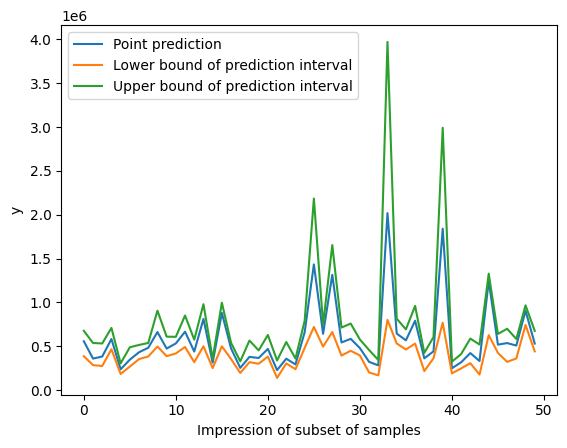

In [15]:
plot_impression_of_subset(point_prediction[:50], conformalized_prediction_intervals[:50, :])

After the calibration, the interval is well calibrated, close to the correct percentage of the test set falls within the confidence interval.

In [16]:
y_test_in_prediction_interval = (y_test >= conformalized_prediction_intervals[:, 0]).astype(int) * (y_test <= conformalized_prediction_intervals[:, 1]).astype(int)
print(f'Percentage of test set within prediction interval with {confidence}: {y_test_in_prediction_interval.mean()}')

Percentage of test set within prediction interval with 0.9: 0.8962709355047654


# Conformal prediction with package MAPIE <a class="anchor" id="MAPIE"></a>

The MAPIE package applies conformalized quantile regression. Within the `fit` function, three quantile regression models are trained: the low quantile, the median and the high quantile of the interval. After training these three models, the calibration set is used to calibrate the interval based on the conformity scores (see previous section for all steps). The prediction gives the prediction combining the quantile regression models with the correction of conformal prediction (= conformalized quantile regression).

Do note, that in the situation that you need a detailed distribution, for example a distribution of 100 or even 1000 quantiles, the median is retrained for every interval. Therefore the training time becomes longer then necessary.

In [17]:
mapie_model = MapieQuantileRegressor(baseline_model, alpha = 1 - confidence) 
mapie_model.fit(X_prop_train, y_prop_train, X_calib=X_cal, y_calib=y_cal)
mapie_point_prediction, mapie_prediction_intervals = mapie_model.predict(X_test)
mapie_prediction_intervals = mapie_prediction_intervals.squeeze()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 8104, number of used features: 21
[LightGBM] [Info] Start training from score 212000.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 8104, number of used features: 21
[LightGBM] [Info] Start training from score 1154699.750000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 8104, number of used features: 21
[LightGBM] [Info] S

/home/inge/Projects/optimisation/venv/lib/python3.10/site-packages/mapie/utils.py:484: UserWarning: WARNING: The predictions of the quantile regression have issues.
The upper quantile predictions are lower
than the lower quantile predictions
at some points.
  warnings.warn(
/home/inge/Projects/optimisation/venv/lib/python3.10/site-packages/mapie/utils.py:502: UserWarning: WARNING: The predictions have issues.
The upper predictions are lower thanthe lower predictions at some points.
  warnings.warn(


The interval varies over time.

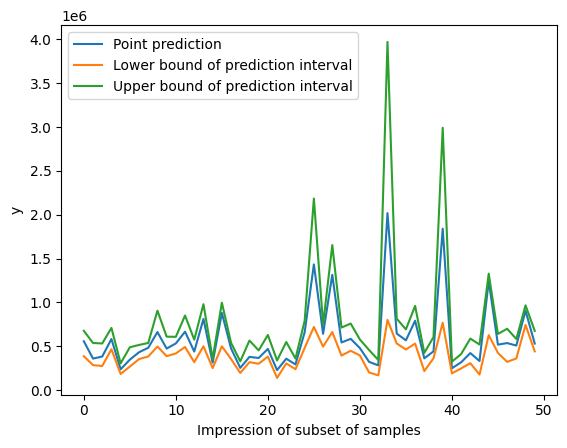

In [18]:
plot_impression_of_subset(mapie_point_prediction[:50], mapie_prediction_intervals[:50, :])

The interval is well calibrated, close to the correct percengtage of the test set falls within the confidence interval.

In [19]:
y_test_in_prediction_interval = (y_test >= mapie_prediction_intervals[:, 0]).astype(int) * (y_test <= mapie_prediction_intervals[:, 1]).astype(int)
print(f'Percentage of test set within prediction interval with {confidence}: {y_test_in_prediction_interval.mean()}')

Percentage of test set within prediction interval with 0.9: 0.8962709355047654


# Conformal prediction with package crepes <a class="anchor" id="crepes"></a>

This packages applies conformal prediction instead of conformalized quantile regression.

In [20]:
rf = WrapRegressor(baseline_model)
rf.fit(X_prop_train, y_prop_train)
rf.calibrate(X_cal, y_cal)
prediction_cqr_interim_lower = rf.predict_int(X_test, confidence=0.90)
prediction_cqr_interim_higher = rf.predict_int(X_test, confidence=0.90)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 8104, number of used features: 21
[LightGBM] [Info] Start training from score 451200.500000


In [21]:
crepes_prediction_intervals =  np.zeros([len(X_test), 2])
crepes_prediction_intervals[:,0] = prediction_cqr_interim_lower[:,0]
crepes_prediction_intervals[:,1] = prediction_cqr_interim_higher[:,1]

The interval is constant of time.

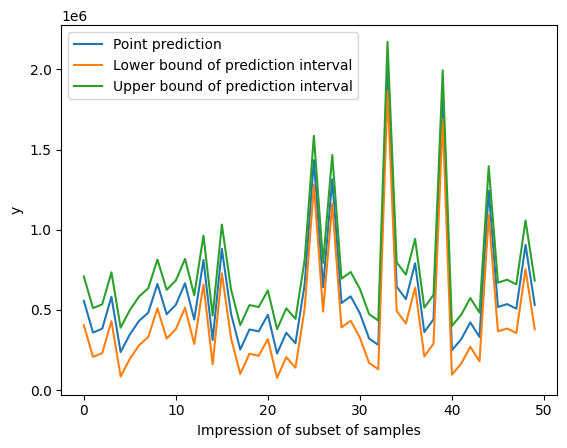

In [26]:
plot_impression_of_subset(point_prediction[:50], crepes_prediction_intervals[:50, :])

In [23]:
y_test_in_prediction_interval = (y_test >= crepes_prediction_intervals[:, 0]).astype(int) * (y_test <= crepes_prediction_intervals[:, 1]).astype(int)
print(f'Percentage of test set within prediction interval with {confidence}: {y_test_in_prediction_interval.mean()}')

Percentage of test set within prediction interval with 0.9: 0.9033959470713426


# Comparison of results: manual, crepes and MAPIE <a class="anchor" id="comparison"></a>

The goal of a predicted probabilistic distribution or a prediction interval is to be as precise (narrow) as possible, while maintaining the correct coverage. Therefore we compare the coverage and size of the interval.

In [24]:
all_intervals = {
    'quantile regression': quantile_regression_prediction_intervals,
    'conformalized quantile regression': conformalized_prediction_intervals,
    'conformalized quantile regression with MAPIE': mapie_prediction_intervals,
    'conformal prediction with crepes': crepes_prediction_intervals,
}

In [25]:
coverages = []
mean_sizes = []
median_sizes = []

for method, intervals in all_intervals.items():
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and
                                   y_test[i]<=intervals[i,1]) else 0
                            for i in range(len(y_test))])/len(y_test))
    mean_sizes.append((intervals[:,1]-intervals[:,0]).mean())
    median_sizes.append(np.median((intervals[:,1]-intervals[:,0])))

pred_int_df = pd.DataFrame({"Coverage":coverages,
                            "Mean size":mean_sizes,
                            "Median size":median_sizes},
                           index=list(all_intervals.keys()))

pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(),
                           pred_int_df["Mean size"].mean(),
                           pred_int_df["Median size"].mean()]

display(pred_int_df.round(4))

,Coverage,Mean size,Median size
quantile regression,0.8248,272806.7208,196484.3986
conformalized quantile regression,0.8963,312184.3845,235862.0623
conformalized quantile regression with MAPIE,0.8963,312184.3845,235862.0623
conformal prediction with crepes,0.9034,303946.8077,303946.8077
Mean,0.8802,300280.5744,243038.8327
